In [1]:
import numpy as np
from scipy.stats import pearsonr
from pathlib import Path
import os
from glob import glob
from collections import defaultdict

%matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
from ase.io import read
from ase import units
from ase.md.npt import NPT
from tqdm.auto import tqdm

from mace.calculators.foundations_models import mace_mp
from mace.calculators import MACECalculator

/home/mike/miniconda3/envs/cascade/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ls md/packmol-CH4-in-H2O\=32-seed\=0-blyp-np-npt\=298-calc\=mace_small_pretrained/

md.log  md.traj


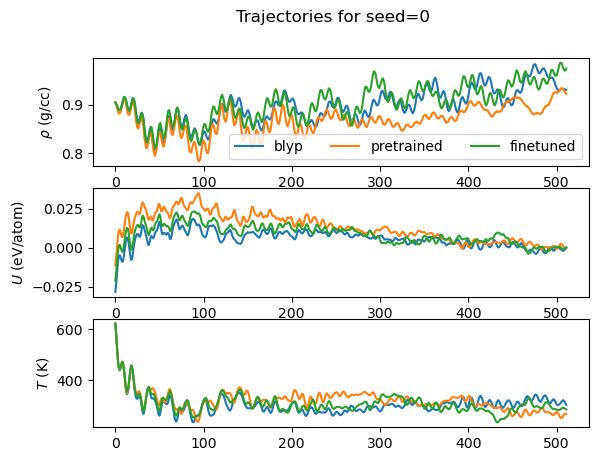

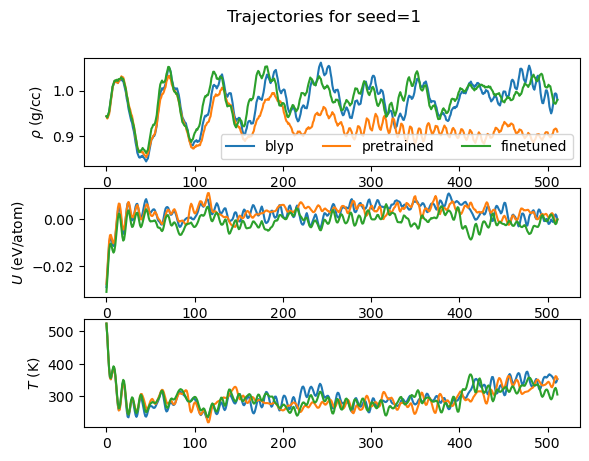

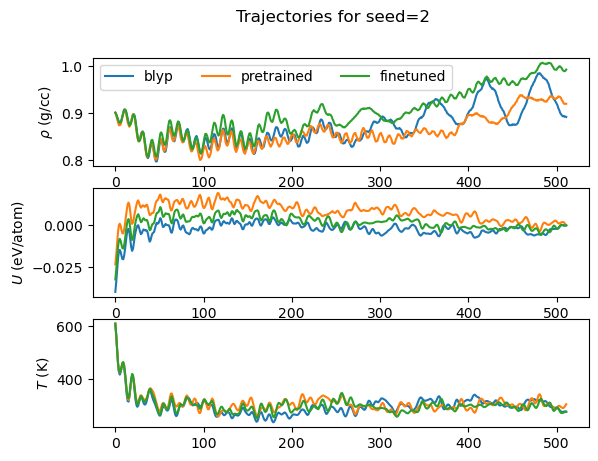

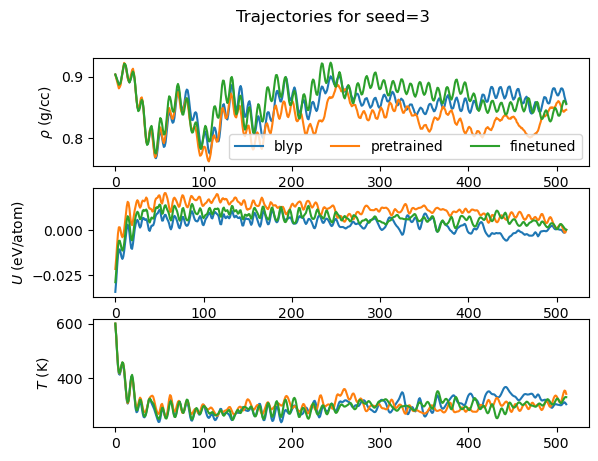

In [3]:
for seed in range(4): 
    fig, axs = plt.subplots(3)
    traj_ref = f'../0_setup/md/packmol-CH4-in-H2O=32-seed={seed}-blyp-npt=298/md.traj'
    traj_pt  = f'./md/packmol-CH4-in-H2O=32-seed={seed}-blyp-np-npt=298-calc=mace_small_pretrained/md.traj'
    traj_ft  = f'./md/packmol-CH4-in-H2O=32-seed={seed}-blyp-np-npt=298-calc=mace_small_finetuned/md.traj'
    traj_ref, traj_pt, traj_ft = map(lambda f: read(f, index=':'), [traj_ref, traj_pt, traj_ft])

    trajectories = [('blyp', traj_ref), ('pretrained', traj_pt), ('finetuned', traj_ft)]
    for name, trajectory in trajectories:
        density = [a.get_masses().sum() / a.get_volume() * units.m ** 3 / units.kg / 1000 for a in trajectory]
        energy  = [(a.get_potential_energy() - trajectory[-1].get_potential_energy()) / len(a) for a in trajectory]
        T = [a.get_temperature() for a in trajectory]
        axs[0].plot(density, label=name)
        axs[1].plot(energy, label=name)
        axs[2].plot(T, label=name)
    axs[0].set_ylabel('$\\rho$ (g/cc)')
    axs[1].set_ylabel('$U$ (eV/atom)')
    axs[2].set_ylabel('$T$ (K)')
    axs[0].legend(ncol=3)
    plt.suptitle(f'Trajectories for {seed=}')
    plt.show()

## Force Error and UQs

In [4]:
forces_dft = [np.load(fn)['arr_0'] for fn in sorted(glob('md/*finetuned/forces.npz'))]

In [5]:
trajectories_ft = [read(fn, index=':') for fn in sorted(glob('md/*finetuned/md.traj'))]

In [6]:
forces_comm = [np.load(fn)['arr_0'] for fn in sorted(glob('md/*finetuned/forces_comm.npz'))]

In [7]:
forces_dft[0].shape

(512, 101, 3)

In [8]:
forces_comm[0].shape

(512, 4, 101, 3)

In [9]:
# each array is (n_trajectories, n_timesteps)
force_error_avg, force_error_max = np.zeros((4, 512)), np.zeros((4,512))
force_uq_avg, force_uq_max = np.zeros((4, 512)), np.zeros((4,512))
for seed in range(4):
    traj = trajectories_ft[seed]
    for timestep in range(len(traj)): 
        atoms = traj[timestep]
        forces = atoms.get_forces()
        ref_forces = forces_dft[seed][timestep]
        # look at the absolute force error
        force_error = np.abs(forces - ref_forces)
        # and the stdev of the predicted forces along the ensemble direction
        force_uq = np.sqrt(forces_comm[seed][timestep].var(0))
        # the l2 norm of the force error/uq for each atom
        force_error, force_uq = map(lambda a: np.linalg.norm(a, axis=1), (force_error, force_uq))
        # save max, average
        force_error_avg[seed,timestep] = force_error.mean()
        force_error_max[seed,timestep] = force_error.max()
        force_uq_avg[seed,timestep] = force_uq.mean()
        force_uq_max[seed,timestep] = force_uq.max()

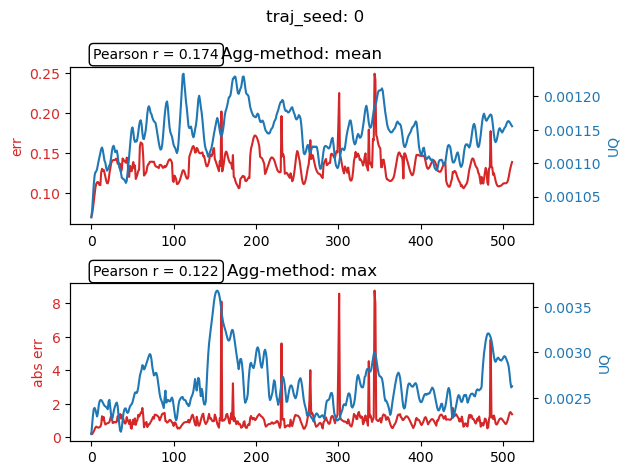

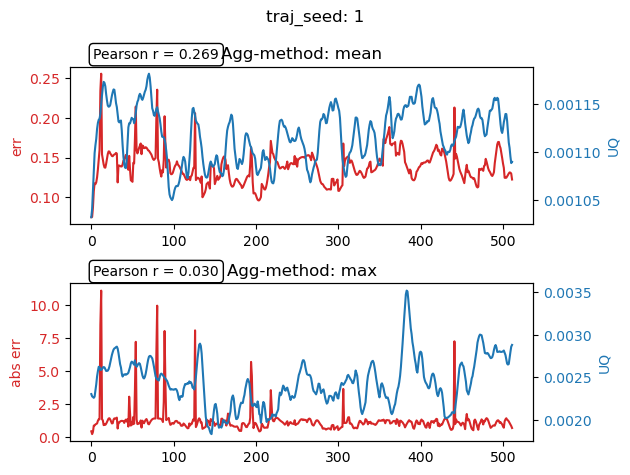

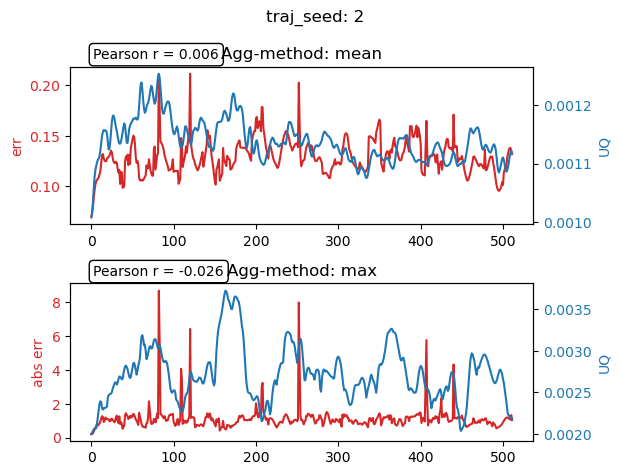

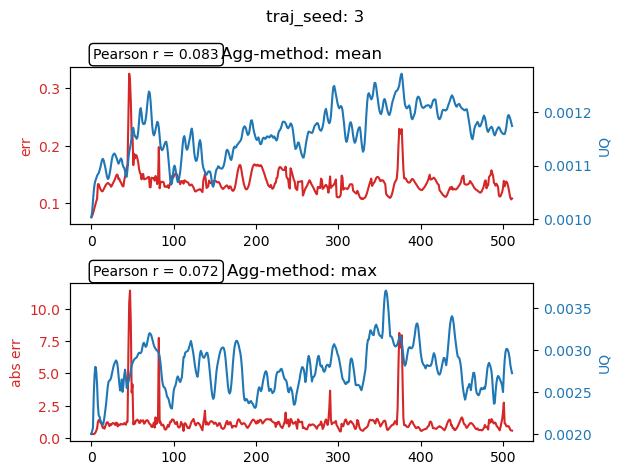

In [10]:
for seed in range(4): 
    fig, axes = plt.subplots(2)
    
    # first plot the average error and UQ together
    ax1 = axes[0]
    ax1.set_title('Agg-method: mean')
    
    err = force_error_avg[seed]
    uq = force_uq_avg[seed]

    ax1.set_title('Agg-method: mean')
    
    t = ax1.text(0.05, 1.05, 
                f'Pearson r = {pearsonr(err, uq)[0]:0.3f}', 
                transform=ax1.transAxes)
    t.set_bbox(dict(boxstyle='round', facecolor='white'))
    
    ## twinx with error in red
    color = 'tab:red'
    ax1.set_ylabel('err', color=color)
    ax1.plot(err, label='err', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ## and uq in blue
    ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('UQ', color=color)  # we already handled the x-label with ax1
    ax2.plot(uq, color=color)
    ax2.tick_params(axis='y', labelcolor=color)


    # now do the same thing with the max aggregation method 
    err = force_error_max[seed]
    uq = force_uq_max[seed]
    ax1 = axes[1]

    t = ax1.text(0.05, 1.05, 
            f'Pearson r = {pearsonr(err, uq)[0]:0.3f}', 
            transform=ax1.transAxes)
    t.set_bbox(dict(boxstyle='round', facecolor='white'))
    ax1.set_title('Agg-method: max')
    color = 'tab:red'
    ax1.set_ylabel('abs err', color=color)
    ax1.plot(err, label='err', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('UQ', color=color)  # we already handled the x-label with ax1
    ax2.plot(uq, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    plt.suptitle(f'traj_seed: {seed}')
    plt.tight_layout()
    plt.show()

Thats really just okay

## Compute memberwise uncertainty

In [11]:
# iterate over all of the initial geometries
force_member_uq = []
for traj_seed in range(4):
    # read the corresponding reference DFT-driven trajectory
    reference_traj =  f'../0_setup/md/packmol-CH4-in-H2O=32-seed={traj_seed}-blyp-npt=298/md.traj'
    reference_traj = read(reference_traj, index=':')
    
    # read in all of the ensemble member trajectories
    member_trajectories = []
    for member_seed in range(4):
        member_traj = f'md/packmol-CH4-in-H2O=32-seed={traj_seed}-blyp-np-npt=298-calc=mace_small_finetuned-ensemble_ix={member_seed}/md.traj'
        member_traj = read(member_traj, index=':')
        member_trajectories.append(np.asarray([atoms.positions for atoms in member_traj]))

    # this is an array of *positions* 
    # with shape: n_members, n_timesteps, n_atoms, 3 (spatial)
    member_trajectories = np.asarray(member_trajectories)
    
    # take variance along the n_members dimension
    # now has shape: n_timesteps, n_atoms, 3 (spatial)
    member_variance = member_trajectories.var(0)

    # take the mean along the n_atoms, 3 (spatial) dimensions
    member_variance = member_variance.mean((1,2))
    force_member_uq.append(member_variance)

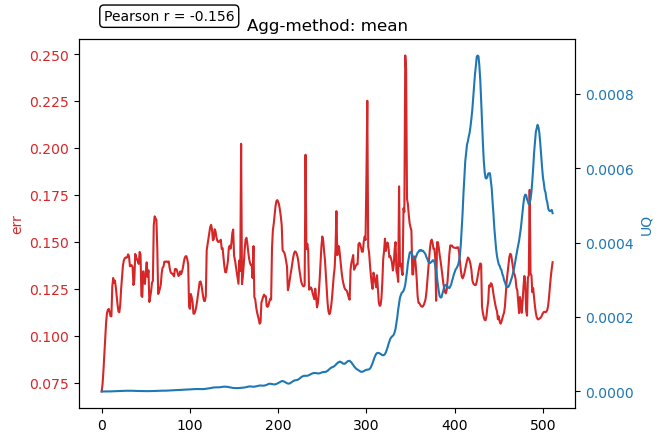

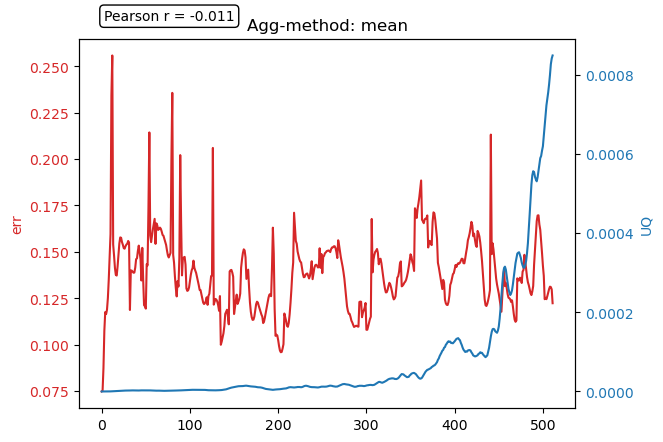

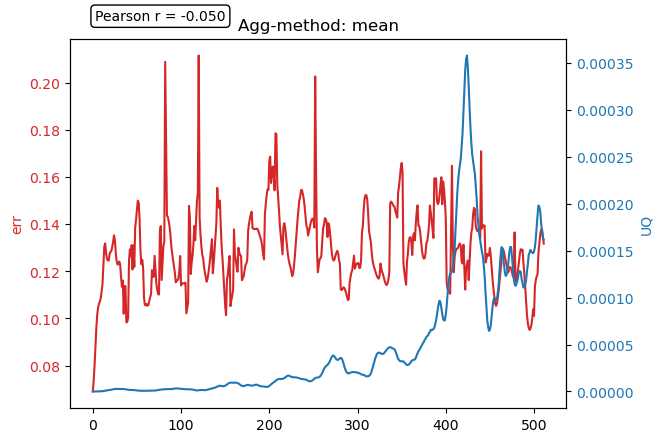

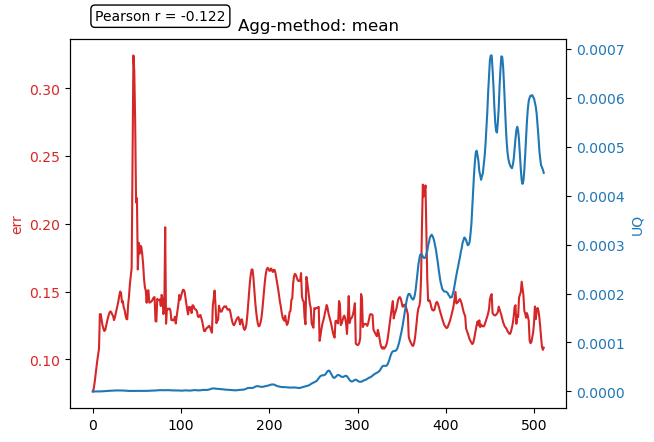

In [12]:
for seed in range(4): 
    fig, axes = plt.subplots()
    # first plot the average error and UQ together
    ax1 = axes
    ax1.set_title('Agg-method: mean')
    
    err = force_error_avg[seed]
    uq = force_member_uq[seed]

    ax1.set_title('Agg-method: mean')
    
    t = ax1.text(0.05, 1.05, 
                f'Pearson r = {pearsonr(err, uq)[0]:0.3f}', 
                transform=ax1.transAxes)
    t.set_bbox(dict(boxstyle='round', facecolor='white'))
    
    ## twinx with error in red
    color = 'tab:red'
    ax1.set_ylabel('err', color=color)
    ax1.plot(err, label='err', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ## and uq in blue
    ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('UQ', color=color)  # we already handled the x-label with ax1
    ax2.plot(uq, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

Not sure what I was expecting